# PharmSci 175/275 (UCI)
## What is this?? 
The material below is a Jupyter notebook including some lecture content to supplement class material on fluctuations, correlations, and error analysis from Drug Discovery Computing Techniques, PharmSci 175/275 at UC Irvine. 
Extensive materials for this course, as well as extensive background and related materials, are available on the course GitHub repository: [github.com/mobleylab/drug-computing](https://github.com/mobleylab/drug-computing)

This material is a set of slides intended for presentation with RISE as detailed [in the course materials on GitHub](https://github.com/MobleyLab/drug-computing/tree/master/uci-pharmsci/lectures/energy_minimization). While it may be useful without RISE, it will also likely appear somewhat less verbose than it would if it were intended for use in written form.

# Fluctuations, correlations, and error analysis

Today: Chemistry tools in Python; working with molecules; generating 3D conformers; shape search methods

### Instructor: David L. Mobley

### Contributors to today's materials:
- David L. Mobley
- I also appreciate John Chodera and Nathan Lim for help with OpenMM
- Some content also draws on John Chodera's work on [automated equilibration detection](https://www.biorxiv.org/content/early/2015/12/30/021659) and his [`pymbar`](https://github.com/choderalab/pymbar) Python package
- Density calculation work uses code from a former postdoc, Gaetano Calabró

# Outline of this notebook
1. Recap/info on central limit theorem and averaging
1. Some brief OpenMM basics -- mostly not covered in detail in class, but provides context for the density calculation
2. A simple example of a density calculation which stops when converged
3. Analyzing density results in this notebook

# Remember, the central limit thereom means the of a sum of many independent random variables is a Gaussian/normal distribution

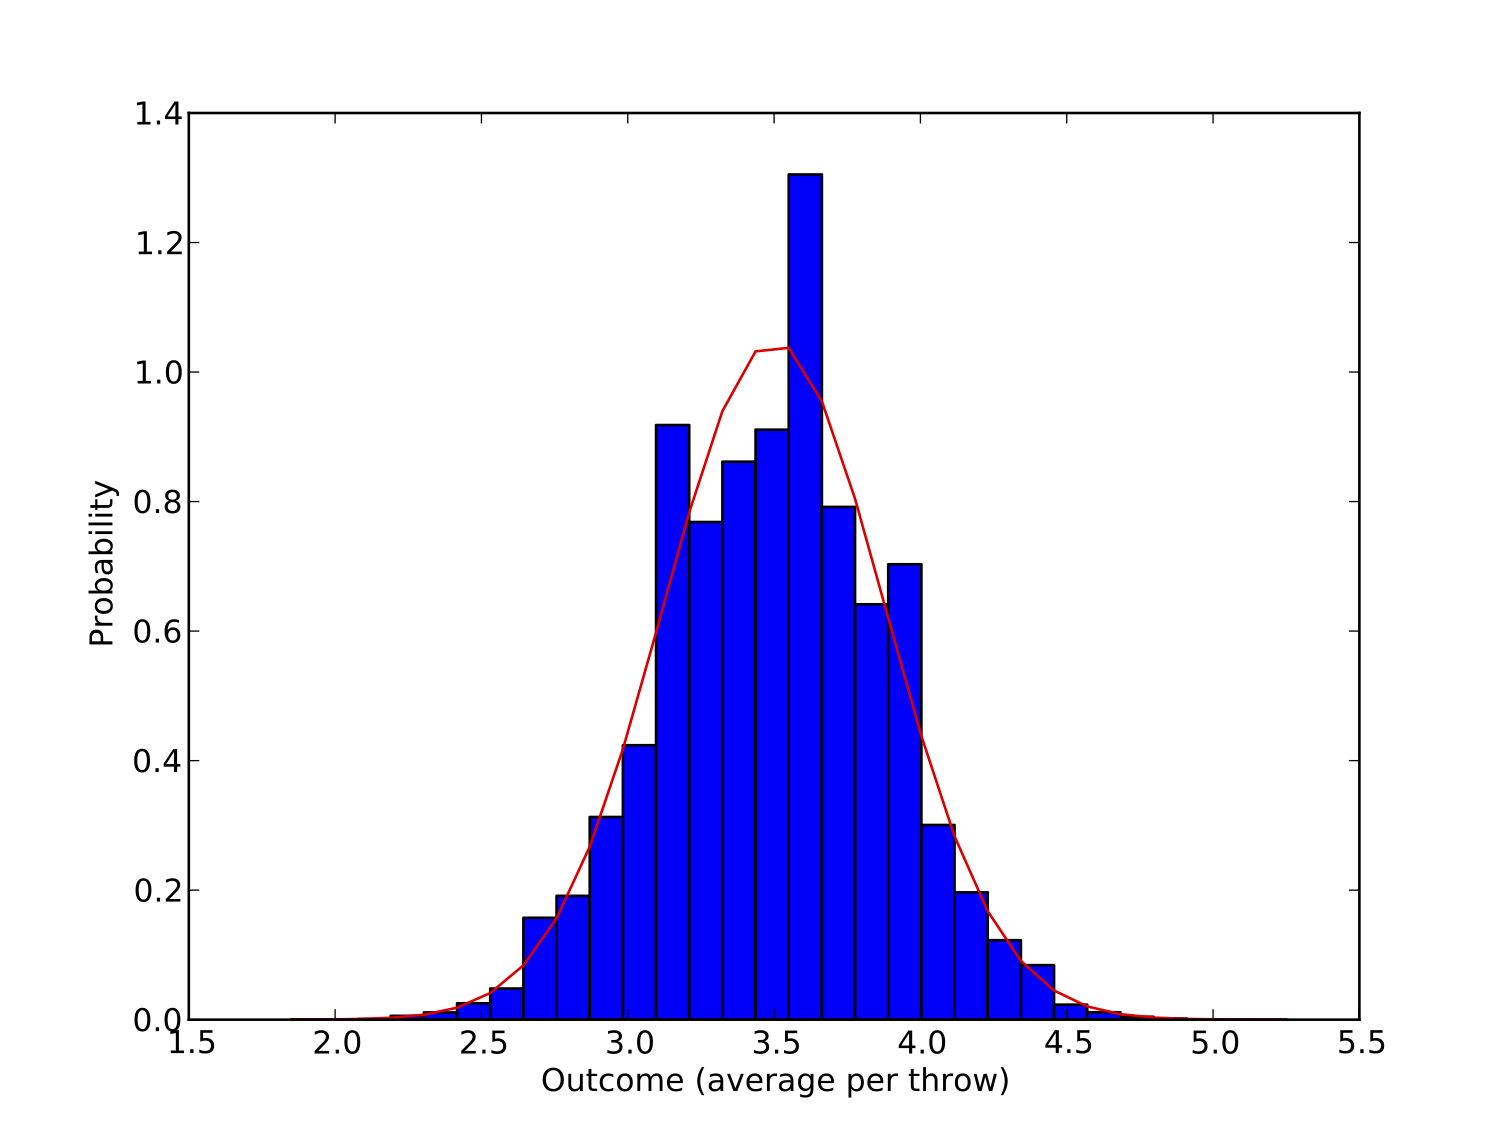

In [1]:
from IPython.display import Image
Image('images/CLT.png')

## This is true regardless of the starting distribution

The distribution of a sum of many independent random variables will follow a Gaussian (normal) distribution, regardless of the starting distribution

A mean is a type of sum, so a mean (average) of many measurements or over many molecules will often be a normal distribution

## But which property? Sometimes several properties are related

Sometimes, related properties can be calculated from the same data -- for example, binding free energy:
$\Delta G_{bind} = k_B T \ln K_d$

Which should be normally dsitributed? $K_d$? $\Delta G$? Both? 

Answer: Free energy, typically. Why? Equilibrium properties are determined by free energy. We measure, for example, the heat released on binding averaged over many molecules. We might *convert* to $K_d$, but the physical quantity relates to the free energy.

## This has important implications for averaging

For example, obtain results from several different experiments (i.e. different groups) and want to combine. How to average?

$\Delta G_{bind} = k_B T \ln K_d$

Example: combining vapor pressure measurements as part of a hydration free energy estimate: Three values, 1e-3, 1e-4, 1e-5. (Vapor pressure determined by partitioning between gas and condensed phase -- driven by free energy. It is the free energy which should be normally distributed, not the vapor pressure.)

**Simple mean:  3.7e-4**
**Average the logarithms and exponentiate: 1e-4**

**So, average the free energy, NOT the $K_d$.**
This also applies to other areas -- partitioning coefficients, solubility, etc. 

# Generate some input files we'll use

- We want some inputs to work with as we see how OpenMM works
- And for our sample density calculation
- We use the [Evaluator](https://openff-evaluator.readthedocs.io/en/stable/index.html) package to build the systems to simulate. This package does a lot more that we're not using here because it's outside scope. 

Previously this notebook used a simple set of wrappers my lab had put together, [`SolvationToolkit`](https://github.com/mobleylab/SolvationToolkit), which uses the [`packmol`](https://github.com/mcubeg/packmol) tool for preparing mixtures. However, that's not really maintained so we now use OpenFF's `evaluator`.

## Prerequisites: The normal stuff, PLUS OpenFF Evaluator
To use what follows, you will need the standard conda/miniconda/mamba installation for the class, and **additionally OpenFF Evaluator** which you can install via `conda install -c conda-forge -c omnia openff-evaluator` or `mamba install -c conda-forge -c omnia openff-evaluator`. You will also want the OpenEye toolkits installed (along with their license). If you're on Google Colab, [these instructions are probably the best place to draw from](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb).


## Get going:

In [22]:
from openff.interchange.components._packmol import UNIT_CUBE, pack_box
from openff.units import unit, Quantity


from openff.toolkit.topology import Molecule
phenol = Molecule.from_smiles("c1ccccc1O")
toluene = Molecule.from_smiles("Cc1ccccc1")
cyclohexane = Molecule.from_smiles("C1CCCCC1")

packed_topology = pack_box([phenol, toluene, cyclohexane], [1, 10, 140], target_density = 1.0*unit.gram/unit.mL,
        working_directory = '2025', retain_working_files=True)

# OpenMM is more of a simulation toolkit than a simulation package

(This material is here mainly as background for the code below, down to [A simple example of a density calculation which stops when converged](#A-simple-example-of-a-density-calculation-which-stops-when-converged), and will not be covered in detail in this lecture).

- Easy-to-use Python API
- Very fast calculations on GPUs (but slow on CPUs)
- Really easy to implement new techniques, do new science
- Key ingredients in a calculation:
    - `Topology`
    - `System`
    - `Simulation` (takes `System`, `Topology`, `Integrator`; contains positions)

## `Topology`: Chemical composition of your system

- Atoms, bonds, etc.
- Can be loaded from some common file formats such as PDB, mol2
- Can be created from OpenEye molecule via [`oeommtools`](https://github.com/oess/oeommtools), such as [`oeommtools.utils.oemol_to_openmmTop`](https://github.com/oess/oeommtools/blob/master/oeommtools/utils.py#L17)
    - Side note: An OE "molecule" can contain more than one molecule, so can contain protein+ligand+solvent for example
- Tangent: Try to retain bond order info if you have it (e.g. from a mol2)

In [7]:
# Example Topology generation from a couple mechanisms:

# Load a PDB
from simtk.openmm.app import PDBFile
pdb = PDBFile('sample_files/T4-protein.pdb')
t4_topology = pdb.topology

In [8]:
# Load a mol2: MDTraj supports a variety of file formats including mol2
import mdtraj
traj = mdtraj.load('sample_files/mobley_20524.mol2')
# MDTraj objects contain a Topology, but an MDTraj topology; they support conversion to OpenMM
traj.topology.to_openmm()

# MDTraj can also handle PDB, plus trajectory formats which contain topology information
protein_traj = mdtraj.load('sample_files/T4-protein.pdb')
t4_topology = protein_traj.topology.to_openmm()
# And we can visualize with nglview (or drop out to VMD)
import nglview
view = nglview.show_mdtraj(protein_traj)
view

/Users/davidmobley/miniforge3/envs/drugcomp/lib/python3.12/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


NGLWidget()

In [9]:
try:
    import openmm
    from openmm import app
except ImportError:
    from simtk import openmm, app

# Load AMBER gas phase topology
prmtop = openmm.app.AmberPrmtopFile('sample_files/mobley_20524.prmtop')
print("Topology has %s atoms" % prmtop.topology.getNumAtoms())

# Gromacs files can be loaded by GromacsTopFile and GromacsGroFile but you need topology/coordinate files
# which don't have include statements, or a GROMACS installation

Topology has 13 atoms


## `System`: Your parameterized system
- Often generated by `createSystem`, but requires OpenMM know how to assign parameters
  - Easy for standard biomolecules (proteins, nucleic acids), waters ions
  - OpenMM FFXML files used; available for many common FFs
  - More complex for general small molecules
- Can also be loaded from common file formats such as GROMACS, AMBER
  - useful if you set up for AMBER or GROMACS
- We have new open forcefield effort that provides new force fields with an `openforcefield.createSystem` operator; generates OpenMM Systems.

In [10]:
# Example system creation
#From OpenMM Docs: http://docs.openmm.org/latest/userguide/application.html#running-simulations
try:
    import openmm
    from openmm import app
    from openmm import unit
except ImportError:
    from simtk import openmm, app, unit


# Example System creation using OpenMM XML force field libraries -- good for biomolecules, ions, water
pdb = openmm.app.PDBFile('sample_files/input.pdb')
forcefield = openmm.app.ForceField('amber99sb.xml', 'tip3p.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.PME,
        nonbondedCutoff=1*openmm.unit.nanometer, constraints=openmm.app.HBonds)


## `Simulation`: The system, topology, and positions you're simulating, under what conditions
- Could be for energy minimization, or different types of dynamics
- Has an integrator attached (even if just minimizing), including temperature
- `context` -- including positions, periodic box if applicable, etc.
- If dynamics, has:
  - timestep
  - velocities
- potentially also has reporters which store properties like energies, trajectory snapshots, etc.

## Let's build a simple solvent mixture system to simulate


Here we use the OpenFF toolkit and force field. We will need to tell the toolkit what "molecules" we want and then build a topology/system containing these. To work with them in OpenFF, we need full chemical details of the molecules involved, so we create OpenFF `Molecule` objects from SMILES strings so it knows what exactly we're working with. These Molecules have considerable chemical detail and are a requirement for assigning OpenFF parameters to the full system.

In [43]:
# Import some OpenFF tools to use
from openff.interchange.components._packmol import UNIT_CUBE, pack_box
from openff.units import unit, Quantity

from openff.toolkit.topology import Molecule

# Define the molecules that will comprise our system
phenol = Molecule.from_smiles("c1ccccc1O")
toluene = Molecule.from_smiles("Cc1ccccc1")
cyclohexane = Molecule.from_smiles("C1CCCCC1")

# Create a topology out of these components, packing a box
packed_topology = pack_box([phenol, toluene, cyclohexane], [1, 10, 140], target_density = 1.0*unit.gram/unit.mL,
        working_directory = '2025', retain_working_files=True)

## Next we load a force field and create an OpenMM system

In [44]:
# Load force field
forcefield = ForceField("openff-2.0.0.offxml")

# Create OpenMM system from OpenFF topology
system = forcefield.create_openmm_system(packed_topology)

Now that we've done that, we go ahead and set up for a simulation and then do an energy minimization:

In [45]:
#Do imports
try:
    import openmm
    from openmm import unit
except ImportError:
    from simtk import openmm, unit

# Prepare the integrator
integrator = openmm.openmm.LangevinMiddleIntegrator(300*openmm.unit.kelvin, 1/openmm.unit.picosecond, 0.002*openmm.unit.picoseconds)


# Prep the simulation
simulation = openmm.app.Simulation(omm_topology, system, integrator)
positions = pdbfile.getPositions()
simulation.context.setPositions(positions)

In [46]:
# Get and print initial energy
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / openmm.unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Energy minimize
simulation.minimizeEnergy()

# Get and print final energy
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / openmm.unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)

Energy before minimization (kcal/mol): 4.8e+03
Energy after minimization (kcal/mol): 3.8e+03


In [47]:
# While we're at it, why don't we just run a few steps of dynamics
import sys
simulation.reporters.append(openmm.app.PDBReporter('sample_files/mixture_output.pdb', 100))
simulation.reporters.append(openmm.app.StateDataReporter(sys.stdout, 100, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(1000) # Runs 1000 steps of dynamics
state = simulation.context.getState(getEnergy=True, getPositions=True)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,17157.04162585268,57.11195286732014
200,18253.11303698549,103.37917857539684
300,18942.87023913393,140.58776644381237
400,19822.22729479799,168.0460935351116
500,20492.08459460268,193.57227045390357
600,20833.860839719866,210.93963330054297
700,21295.114745969866,224.3494695882381
800,21421.524902219866,241.1816583947492
900,21762.33178698549,250.05477367125368
1000,22097.864257688616,248.56059177445317


# A simple example of a density calculation which stops when converged

- We'll do a very simple density estimation
- This is not a recommended protocol since we're just jumping straight in to "production"
- But it illustrates how you can do this type of thing easily with OpenMM
- For production data, you'd precede by equilibration (usually NVT, then NPT, then production)

## The most bare-bones version

This picks up from the example just prior and adds a barostat so that we can bring the system to the correct density and pressure.

(Note if you want to run this again you may need to re-run some of the prep above.)

In [48]:
# We'll pick up that same system again, loading it up again so we can add a barostat before setting up the simulation

output_file_prefix = 'mysimulation'

# Now add a barostat
system.addForce(openmm.MonteCarloBarostat(1*openmm.unit.atmospheres, 300*openmm.unit.kelvin, 25))

# Set up integrator and simulation
integrator = openmm.openmm.LangevinMiddleIntegrator(300*openmm.unit.kelvin, 1/openmm.unit.picosecond, 0.002*openmm.unit.picoseconds)
simulation = openmm.app.Simulation(pdbfile.topology, system, integrator)


# Let's pull the positions from the end of the brief "equilibration" we ran up above.
simulation.context.setPositions(state.getPositions())


# Set up a reporter to assess progress; will report every 100 steps (somewhat short)
prod_data_filename = os.path.join('sample_files', os.path.basename(output_file_prefix)+'.csv')
simulation.reporters.append(app.StateDataReporter( prod_data_filename, 100, step=True, potentialEnergy=True,
                                                  temperature=True, density=True))


In [49]:
# Here we will use OpenFF Interchange to store files for possible reuse later
from openff.interchange import Interchange

# Set up for run; for a somewhat reasonable convergence threshold you probably want run_steps >= 2500
# and a density tolerance of 1e-3 or smaller; higher thresholds will likely result in early termination
# due to slow fluctuations in density.
# But that may take some time to run, so feel free to try higher also.
run_steps = 2500
converged = False
density_tolerance = 0.001
import pandas as pd
from pymbar import timeseries as ts
import numpy as np

# Load force field
sage = ForceField("openff-2.0.0.offxml")
# Set up an Interchange object so we can export to other file formats/simulation packages
interchange = Interchange.from_smirnoff(topology=packed_topology, force_field=sage, box=packed_topology.box_vectors)

# Export GROMACS file for possible reuse later.
identifier = "phenol_toluene_cyclohexane"
data_path = "mixtures"
import os
if not os.path.isdir(data_path): os.mkdir(data_path)
interchange.to_top(os.path.join(data_path, f"{identifier}.top"))
interchange.to_gro(os.path.join(data_path, f"{identifier}.gro"))



In [50]:
while not converged:
    simulation.step(run_steps)

    # Read data
    d = pd.read_csv(prod_data_filename, names=["step", "U", "Temperature", "Density"], skiprows=1)
    density_ts = np.array(d.Density)
    
    # Detect when it seems to have equilibrated and clip off the part prior
    [t0, g, Neff] = ts.detect_equilibration(density_ts)
    density_ts = density_ts[t0:]
    
    # Compute standard error of what's left
    density_mean_stderr = density_ts.std() / np.sqrt(Neff)

    # Print stats, see if converged
    print("Current density mean std error = %f g/mL" % density_mean_stderr)

    if density_mean_stderr < density_tolerance :
        converged = True
        print("...Convergence is OK; equilibration estimated to be achieved after data point %s\n" % t0)

Current density mean std error = 0.001712 g/mL
Current density mean std error = 0.001558 g/mL
Current density mean std error = 0.002043 g/mL
Current density mean std error = 0.002262 g/mL
Current density mean std error = 0.002271 g/mL
Current density mean std error = 0.001249 g/mL
Current density mean std error = 0.000951 g/mL
...Convergence is OK; equilibration estimated to be achieved after data point 166



# While that's running, let's look at what it's doing

## The first key idea is that we want to be able to tell it to stop when the density is known precisely enough

We have this bit of code: 
```python
density_mean_stderr = density_ts.std() / np.sqrt(Neff)
```
This is estimating the standard error in the mean -- $\sigma_{err} = \frac{\sigma}{\sqrt{N_{eff}}}$ where $N_{eff}$ is the number of effective samples and $\sigma$ is the standard deviation.

**We can stop running our simulation when the number of effective samples gets high enough, relative to the standard deviation, that the standard error becomes as small as we want.**

## But how do we get the number of effective samples?

As discussed previously, $N_{eff} = N/g$ where $g$ is the statistical inefficiency -- a measure of how correlated our samples are. 

John Chodera's `pymbar` module provides a handy `statisticalInefficiency` module which estimates this from calculations of the autocorrelation function/autocorrelation time.

## But there's another problem: What if our initial box size (and density) is very bad?

What if we built the box way too small? Or way too big? Then we'll have an initial period where the density is way off from the correct value.

<center><img src="images/Chodera_1_top.png" alt="GitHub" style="width: 800px;"/></center>

Here, instantaneous density of liquid argon averaged over 500 simulations from [Chodera](https://www.biorxiv.org/content/early/2015/12/30/021659)

### This could adversely affect computed properties, unless we throw out some data for equilibration

If we average these results (red) the result is biased relative to the true expectation value out to well past 1000$\tau$ (time units) [(Chodera)](https://www.biorxiv.org/content/early/2015/12/30/021659):

<center><img src="images/Chodera_1_all.png" alt="GitHub" style="width: 1000px;"/></center>

Throwing out 500 initial samples as equilibration gives much better results even by 200 $\tau$

### With a clever trick, you can do this automatically

Key idea: If you throw away unequilibrated data, it reduces the correlation time/statistical inefficiency, **increasing $N_{eff}$**. But if you throw away equilibrated data, you're just wasting data (**decreasing $N_{eff}$**). So pick how much data to throw away to [**maximize $N_{eff}$.**](https://www.biorxiv.org/content/early/2015/12/30/021659)

<center><img src="images/Chodera_2.png" alt="GitHub" style="width: 1000px;"/></center>

### Basically what we're doing here is making a bias/variance tradeoff

We pick an amount of data to throw away that minimizes bias without increasing the variance much

<center><img src="images/Chodera_3.png" alt="GitHub" style="width: 400px;"/></center>

This shows the same argon case, with 500 replicates, and looks at bias and variance as a function of the amount of data discarded (color bar). Throwing out a modest amount of data reduces bias a great deal while keeping the standard error low.

The arrow marks the point automatically selected.

### It turns out `pymbar` has code for this, too, and we use it in our example

```python
# Read stored trajectory data
d = pd.read_csv(prod_data_filename, names=["step", "U", "Temperature", "Density"], skiprows=1)
density_ts = np.array(d.Density)

# Detect when it seems to have equilibrated and clip off the part prior
[t0, g, Neff] = ts.detect_equilibration(density_ts)
density_ts = density_ts[t0:]
```

# Analyzing density results in this notebook

- The above may take some time to converge
- (You can set the threshold higher, which may lead to apparently false convergence)
- Here we'll analyze some sample density data I've provided

## As usual we'll use matplotlib for analysis: First let's view a sample set of density data

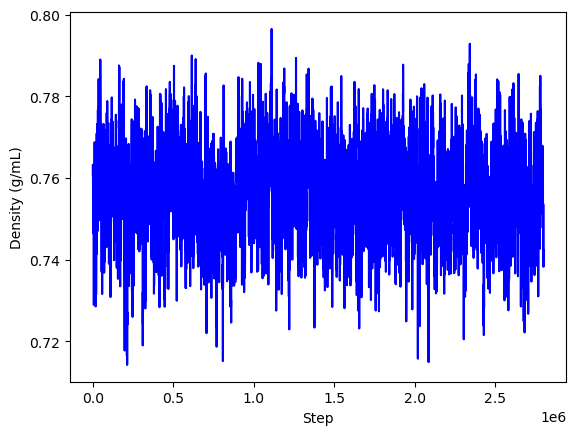

In [39]:
# Prep matplotlib/pylab to display here
%matplotlib inline
import pandas as pd
from pylab import *
from pymbar import timeseries as ts

# Load density

d = pd.read_csv('density_simulation/prod/phenol_toluene_cyclohexane_1_10_100_prod.csv', names=["step", "U", "Temperature", "Density"], skiprows=1)

# Plot instantaneous density

xlabel('Step')
ylabel('Density (g/mL)')
plot( np.array(d.step), np.array(d.Density), 'b-')

## Now we want to detect equilibration and throw out unequilibrated data

We'll also compute the mean density

In [41]:
#Detect equilibration
density_ts = np.array(d.Density)
[t0, g, Neff] = ts.detect_equilibration(density_ts)
print("Data equilibrated after snapshot number %s..." % t0)

# Clip out unequilibrated region
density_ts = density_ts[t0:]
stepnrs = np.array(d.step[t0:])

# Compute mean density up to the present at each time, along with associated uncertainty
mean_density = [ density_ts[0:i].mean() for i in range(2, len(density_ts)) ]
mean_density_stderr = [ ]
for i in range(2,len(density_ts)):
    g = ts.statistical_inefficiency( density_ts[0:i])
    stderr = density_ts[0:i].std()/sqrt(i/g)
    mean_density_stderr.append(stderr)

Data equilibrated after snapshot number 22...


## Finally let's graph and compare to experiment

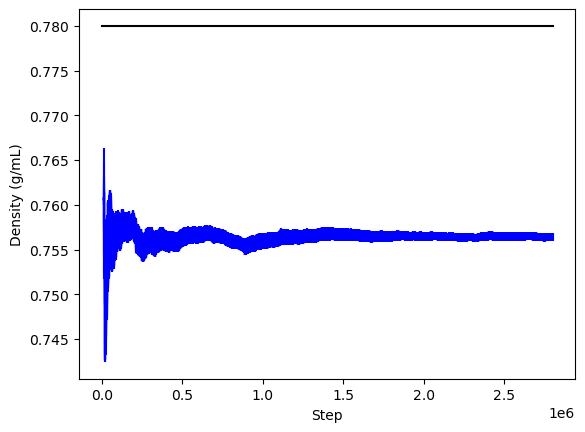

Experimental density of cyclohexane is 0.78 g/mL at 20C


In [42]:
# Plot
figure()
errorbar(stepnrs[2:], mean_density, yerr=mean_density_stderr, fmt='b-' )
plot( [0, stepnrs.max()], [0.78, 0.78], 'k-') #Overlay experimental value for cyclohexane
xlabel('Step')
ylabel('Density (g/mL)')
show()
print("Experimental density of cyclohexane is 0.78 g/mL at 20C" ) # per PubChem, https://pubchem.ncbi.nlm.nih.gov/compound/cyclohexane#section=Solubility

### Exercise: Do the same but for YOUR short simulation

The sample data analyzed here was generated by the `density.py` script in this directory; it discards a lot amount of data to equilibration BEFORE storing production data. This means (as `detectEquilibration` finds) it's already equilibrated.

As an exercise, analyze YOUR sample simulation and find out how much of it has equilibrated/how much data needs to be discarded.

# Now let's shift gears back to some more on statistics and error analysis

The [2013 Computer Aided Drug Design Gordon Research Conference](http://lanyrd.com/2013/grc-cadd-2013/) focused specificially on statistics relating to drug discovery, error, reproducibility, etc. Slides from many talks are available online along with Python code, statistics info, etc. 

Here I draw especially on (with permission) slides from:
- Woody Sherman (then Schrodinger; now Silicon Therapeutics)
- Tom Darden (OpenEye)
- Paul Hawkins (OpenEye)
- John Chodera (MSKCC) and Terry Stouch (JCAMD)

I'd also like to include material from Ajay Jain that I normally show, but am waiting approval, and likewise content from Paul Hawkins (OpenEye)

## Some content from Sherman

<center><img src="images/Sherman_1.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_2.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_3.png" alt="GitHub" style="width: 1000px;"/></center>

### Why do we not know?

**No null hypothesis** -- no point of comparison as to how well we would do with some other model or just guessing or... We don't know what "useful" means!

Null hypothesis used differently in two approaches to statistical inference (same term is used, different meaning):
- **Significance testing** (Fisher): Null hypothesis is rejected or disproved on basis of data but never accepted or proved; magnitude of effect is unimportant
- **Hypothesis testing** (Neyman and Pearson): Contrast with alternate hypothesis, decide between them on basis of data. Must be better than alternative hypothesis. 

Arguably hypothesis testing is more important, though significance testing is done a lot (see last lecture).

Sherman's slides below focus on hypothesis testing.

<center><img src="images/Sherman_4.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_5.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_6.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_7.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_8.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Sherman_9.png" alt="GitHub" style="width: 1000px;"/></center>

### Follow-up note

Sherman explains that Knight subsequently used this as an example of lessons learned/how important statistics are in a job talk at Schrodinger and was hired.

### As a result of this, design hypothesis testing studies carefully

For hypothesis testing/model comparison, pick a null/alternate model which has SOME value

Be careful not to bias your study against certain methods -- i.e. if you construct a test set to have very diverse structures, this will have implications for what types of methods will do well

## Some slides from Tom Darden, OpenEye

<center><img src="images/Darden_1.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Darden_2.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Darden_3.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Darden_4.png" alt="GitHub" style="width: 1000px;"/></center>

<center><img src="images/Darden_5.png" alt="GitHub" style="width: 1000px;"/></center>

## A final reminder from John Chodera and Terry Stouch

<center><img src="images/Chodera_talk_1.png" alt="GitHub" style="width: 1000px;"/></center>